Generate XRD composition "scans" by interpolating between different CoxNix phases. We put in exaggerated (i.e. unphysical) lattice parameter changes to test the peak shift invariance of embedding models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CoNi = pd.read_json("mp-1226076_xrd_Cu_CoNi.json", lines=True)
Co = pd.read_json("mp-1183710_xrd_Cu_Co.json", lines=True)
Ni = pd.read_json("mp-10257_xrd_Cu_Ni.json", lines=True)

In [15]:
%run ../utils.py

In [5]:
def from_json(df):
    patterns = np.array(df.pattern.iloc[0], dtype = object)
    intensities, angles = patterns[:, 0].astype(float), patterns[:, 2].astype(float)
    q = to_q(angles)
    return q, intensities

In [18]:
def df_to_pat(df):
    q, i = from_json(df)
    pat = mk_pattern(i, q, .01)
    return q, i, pat

def plt_pat(df, **kwargs):
    q, i, pat = df_to_pat(df)
    plt.plot(q_grid, pat, **kwargs)
    return q_grid, pat, i, q

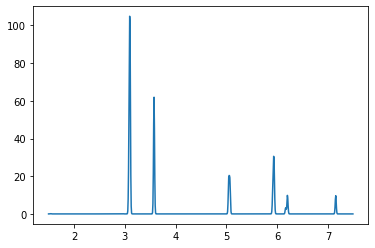

In [19]:
_, _, ib, qb = plt_pat(CoNi);

In [216]:
qb.shape

(31,)

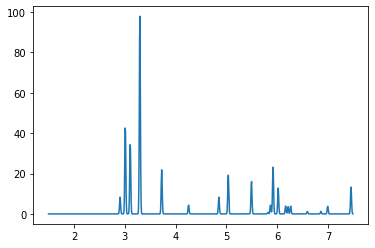

In [250]:
_, _, ia, qa = plt_pat(Co);

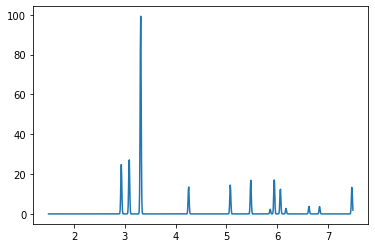

In [21]:
_, _, ic, qc = plt_pat(Ni);

In [152]:
%matplotlib notebook

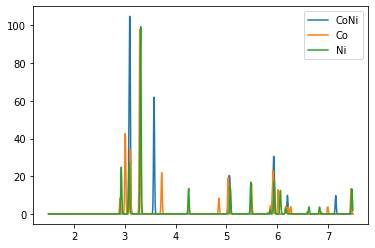

In [22]:
plt_pat(CoNi, label = 'CoNi');
plt_pat(Co, label = 'Co');
plt_pat(Ni, label = 'Ni');
plt.legend()

In [198]:
def transition(start_scale, end_scale, start_pair, end_pair, N, sigma = .01, scale_type = 'scale'):
    """
    pair -> [qs, intensities]
    
    scale_type == 'scale' changes peak positions multiplicatively (in q)
    scale_type == 'shift' shifts peak positions equally (which is not what a lattice parameter change does,
        but it's simpler than doing the q -> log(q) substitution and pretty much equivalent for model testing
        purposes)
        
    TODO
    Lorentz factor
    peak height variation
    """
    scales = np.linspace(start_scale, end_scale, N)
    res = []
    q0, i0 = start_pair
    q1, i1 = end_pair
    
    qq, ii = np.hstack((q0, q1)), np.hstack((i0, i1))
    span = np.abs(start_scale - end_scale)
    for i, s in enumerate(scales):
        if scale_type == 'scale':
            q, i = qq * s, np.hstack((i0 * (N - i) / N, i1 * i / N)) #todo off by one
        elif scale_type == 'shift':
            q, i = qq + s, np.hstack((i0 * (N - i) / N, i1 * i / N)) #todo off by one
        else:
            raise Exception 
        pat = mk_pattern(i, q, sigma)
        res.append(pat)
    return np.vstack(res)

In [219]:
qt, it = np.array([1, 2]), np.array([.5, .6])
qt2, it2 = np.array([2, 3]), np.array([.4, .2])

assert transition(1, 1.5, (qt, it), (qt2, it2), 2).shape == (2, q_grid.shape[0])

In [25]:
sigma = .03
Co_to_CoNi = transition(1, 1.05, (qa, ia), (qb, ib), 200, sigma)

CoNi_to_CoNi = transition(1.05, 1.1, (qb, ib), (qb, ib), 200, sigma)

CoNi_to_Ni = transition(1.1, 1.15, (qb, ib), (qc, ic), 200, sigma)

2D scan of 1D XRD patterns, henceforth known as "the dataset":

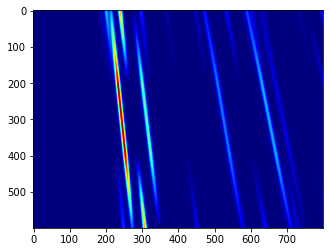

In [29]:
X = np.vstack((Co_to_CoNi, CoNi_to_CoNi, CoNi_to_Ni))
plt.imshow(X, cmap = 'jet')

## NMF decomposition

In [30]:
from sklearn.decomposition import NMF

In [31]:
def do_nmf(n = 10):
    model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000)
    W = model.fit_transform(X.T)
    H = model.components_
    return W, H, np.linalg.norm(np.dot(W, H) - X.T)

In [32]:
nn = np.arange(1, 41, dtype = int)

losses = np.array([do_nmf(n)[2] for n in nn])

/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ollie/anaconda3/l

In [279]:
%matplotlib inline

Text(0, 0.5, 'L2 loss')

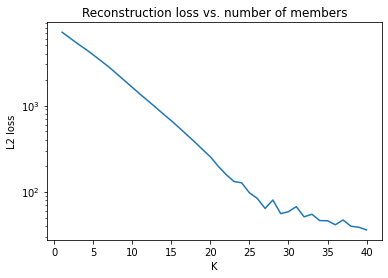

In [35]:
plt.plot(nn, losses)
plt.semilogy()
plt.title("Reconstruction loss vs. number of members")
plt.xlabel("K")
plt.ylabel("L2 loss")

In [33]:
K = 10
W, H, loss = do_nmf(K)
loss

1624.051581484437

Text(0.5, 1.0, 'Original and reconstructed (K = 10)')

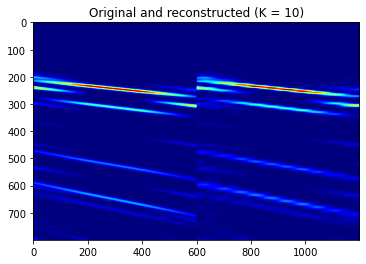

In [34]:
%matplotlib inline
plt.imshow(np.hstack((X.T, (np.dot(W, H)))), cmap = 'jet')
plt.title("Original and reconstructed (K = {})".format(K))

In [319]:
%matplotlib notebook

In [568]:
import tensorflow as tf
from xrdc import sims
from importlib import reload
from xrdc import utils

reload(utils)
reload(sims)

In [572]:
# from tensorflow.keras.datasets import mnist

# a, b = mnist.load_data()

In [39]:
# def to_img(y_cond, size, v_padding = 2):
#     normed = y_cond / y_cond.max()
#     y_indices = (v_padding - 1 + (size - 2 * v_padding) * normed).astype(int)
#     sig2d = np.zeros((size, size))
#     x_indices = np.arange(0, size, step = 1)
#     sig2d[x_indices, y_indices] = 1
#     return sig2d.T[::-1]

In [201]:
def agg(X):
    CoNi_members = X.reshape(20, 30, 800).sum(axis = 1)
    CoNi_y = np.hstack([np.repeat(i, 500) for i in range(20)])[None, :].T
    return CoNi_members, CoNi_y

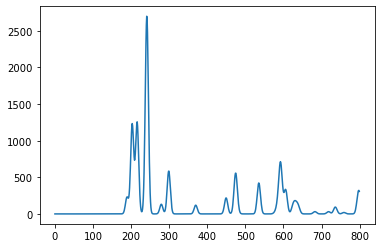

In [265]:
plt.plot(CoNi_members[0])

In [266]:
reload(utils)

<module 'xrdc.utils' from '/Users/ollie/Documents/SLAC/xrdsim/xrdc/utils.py'>

In [267]:
CoNi_members, CoNi_y = agg(X)

CoNi_x, CoNi_y = sims.mk_simdata(CoNi_members, 500, 20, scale_type = 'scale')

scale type: scale


In [268]:
CoNi_test_x, CoNi_test_y = np.repeat(CoNi_test_x, 7, axis = 0)[:10000, :], np.repeat(CoNi_test_y, 7, axis = 0)[:10000]

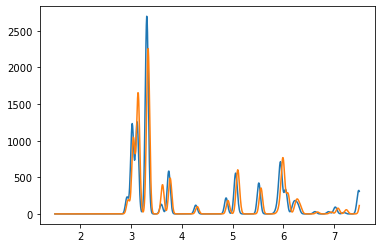

In [237]:
plt.plot(q_grid, CoNi_members[0])
plt.plot(q_grid, CoNi_members[1])

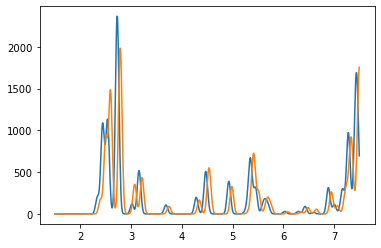

In [239]:
plt.plot(q_grid, CoNi_members_shift[0])
plt.plot(q_grid, CoNi_members_shift[1])

In [195]:
utils.write_train_test("data/CoNi_3/", CoNi_x, CoNi_y, CoNi_x, CoNi_y)

In [199]:
Co_to_CoNi_shift = transition(-.6, -.2, (qa, ia), (qb, ib), 200, sigma, scale_type = 'shift')

CoNi_to_CoNi_shift = transition(-.2, .2, (qb, ib), (qb, ib), 200, sigma, scale_type = 'shift')

CoNi_to_Ni_shift = transition(.2, .6, (qb, ib), (qc, ic), 200, sigma, scale_type = 'shift')

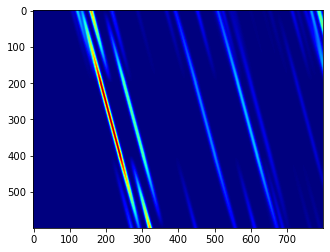

In [202]:
X_shift = np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X_shift, cmap = 'jet')

In [212]:
CoNi_members_shift, CoNi_y_shift = agg(X_shift)

In [214]:
CoNi_x_shift, CoNi_y_shift = sims.mk_simdata(CoNi_members_shift, 500, 20, scale_type = 'shift')

scale type: shift


In [215]:
utils.write_train_test("data/CoNi_shift/", CoNi_x_shift, CoNi_y_shift, CoNi_x_shift, CoNi_y_shift)

In [241]:
assert np.where(np.isnan(CoNi_x) == True)

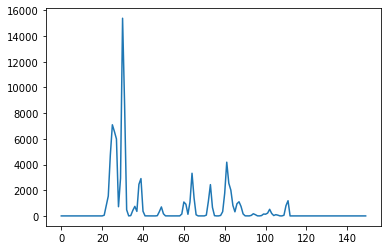

In [269]:
plt.plot(CoNi_x[15])

In [ ]:
def condense(arr, newsize):
    extra = newsize - (len(arr) % newsize)
    arr = np.hstack((arr, np.zeros(extra)))
    return arr.reshape(newsize, -1).sum(axis = 1)

def view_ds(arr):
    """
    2d heatmap of dataset, rows sorted by first moment in q
    """
    plt.imshow(arr[np.argsort(
    (arr * condense(q_grid, 150)).mean(axis = 1)
)].reshape(200, 50, 150).sum(axis = 1))